# Project: Finding lane lines on the road

## 1. Original pictures

First let's have a look at the original pictures. Besides the six test images provided by Udacity I added two images myself. Those are taken from the "challenge" video which is part of the repository as well. Exploring the inital six images one can highlight the following observations:
* all lane lines are straight 
* they always appear in the same general region of the image
* lane lines are painted in high contrast color to the road surface (either white or yellow) 
* light conditions are similar

Things become more challenging with the two images of the "challenge" video.
* slight curvature of lane lines
* light conditions vary because of shadows or bright sunlight
* other cars are much closer
* a part of the car is visible in the bottom of the picture

We need to develop a algorithm which is general as well as robust to detect lane lines reliabely under varying conditions. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
def display_images(images, figsize = (15, 10)):
    "Display images in two columns. Chooses gray-scale colorbar if image is two-dimensional."
    ncols = 2
    nrows = (len(images) // 2) + (len(images) % 2) 
    
    fig = plt.figure(figsize = figsize)
    for i, image in enumerate(images, start = 1):
        ax = fig.add_subplot(nrows, ncols, i)
        plt.imshow(image) if len(image.shape) == 3 else plt.imshow(image, cmap='gray')
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

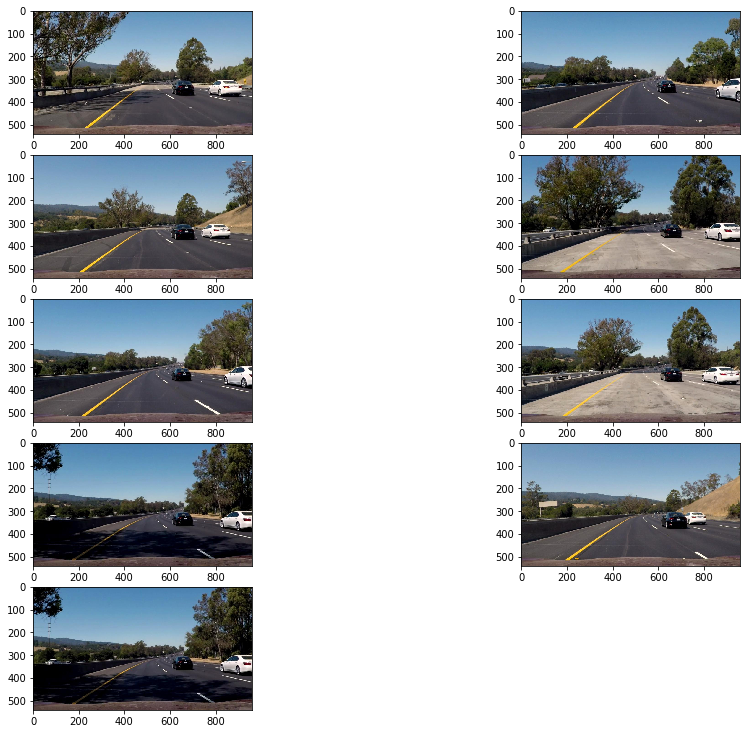

In [3]:
# import images
import glob

images = [mpimg.imread(image) for image in glob.glob("test_images/c*.jpg")]

display_images(images)

## 2. Grayscale transformation

The Cany edge-detection algorithm expects a grayscale image as input. Typically the following formula is applied to conduct grayscale conversion from RGB colorspace
$$Gray = 0.299\cdot R + 0.587\cdot G + 0.114\cdot B.$$
Lane line markings are painted in high contrast colors (white, yellow, red) to the dark road surface. It would be  	advantageous for the application of the Cany algorithms (allows to set higher thresholds) if we choose a transformation which enhances the contrast between a dark pixel and a yellow/white/red pixel. This can be achieved through 
$$Gray = R + G - B.$$

As illustrated in the following toy problem the contrast (i.e. difference in intensities) betweeen white/yellow/red pixels and gray/black pixels is significantly enhanced using $R+G-B$ compared to $0.299\cdot R + 0.587\cdot G + 0.114\cdot B$.

Intensity values of image after grayscale transformation 0.299R+0.587G+0.114B:
white: 255   yellow: 226   red: 76   gray: 140   black: 0
Intensity values of image after grayscale transformation R+G-B:
white: 255   yellow: 255   red: 255   gray: 140   black: 0


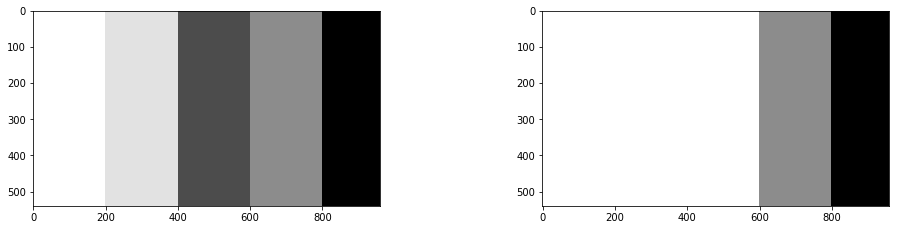

In [5]:
def grayscale(img):
    "Applies the Grayscale transform according to 0.299*R+0.587*G+0.114*B."
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def grayscale2(img):
    "Applies the Grayscale transform according to R+G-B."
    gray = img[:, :, 0].astype('int16') + img[:, :, 1].astype('int16') - img[:, :, 2].astype('int16') 
    gray[gray > 255] = 255
    gray[gray < 0] = 0
    return gray.astype('uint8')


# create picture with white, yellow, red, gray and black regions
imgo = np.zeros_like(np.copy(images[0]))
imgo[:, 0:200]   = [255, 255, 255]
imgo[:, 200:400] = [255, 255, 0]
imgo[:, 400:600] = [255, 0, 0]
imgo[:, 600:800] = [140, 140, 140]
imgo[:, 800:]    = [0, 0, 0]

# grayscale conversion
img_g1 = grayscale(imgo)
img_g2 = grayscale2(imgo)

# intensity values
print('Intensity values of image after grayscale transformation 0.299R+0.587G+0.114B:')
print("white: %d   yellow: %d   red: %d   gray: %d   black: %d" % 
      (img_g1[1, 150], img_g1[1, 250], img_g1[1, 450], img_g1[1, 650], img_g1[1, 850]))
print('Intensity values of image after grayscale transformation R+G-B:')
print("white: %d   yellow: %d   red: %d   gray: %d   black: %d" % 
      (img_g2[1, 150], img_g2[1, 250], img_g2[1, 450], img_g2[1, 650], img_g2[1, 850]))

display_images([img_g1, img_g2], figsize = (15, 3))

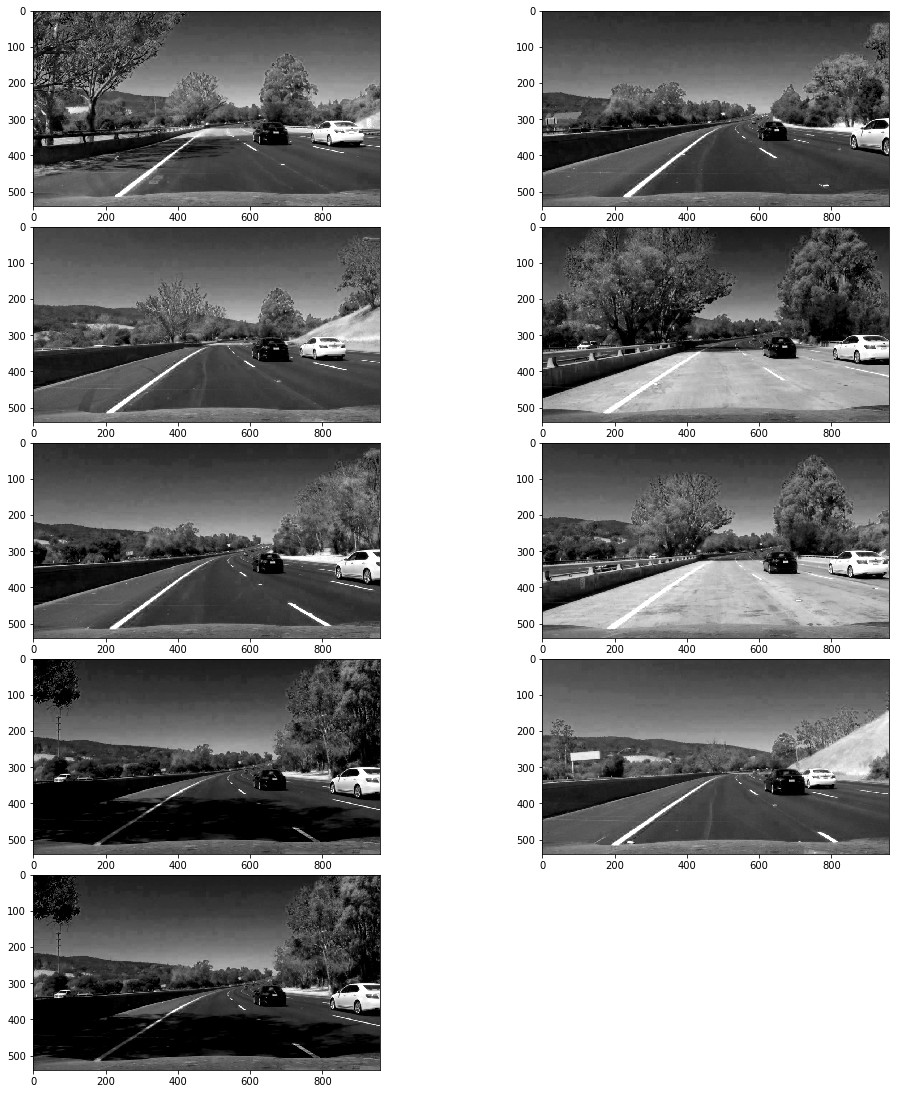

In [6]:
images_gray = np.copy(images)   

images_gray = [grayscale2(image) for image in images_gray]

    
display_images(images_gray, figsize = (15, 15))

## 3. Canny edge detection

Next we apply the Canny edge detection algorithm to the images. The algorithm consits of four steps
* apply a Gaussian filter in order to smooth the image 
* compute magnitude of the gradient vector for each pixel
* apply a double thresholding to the gradient
    * if gradient is larger than high threshold pixel is regarded as an edge
    * if gradient is smaller than the low threshold pixel is disgarded
    * if gardient is between high and low threshold pixel is marked as a potential edge
* check if "potential edge" pixels are connected to strong edges
    * if yes: regard them as edges
    * if no: disgard them
The algorithm tries to preserve pixels with high gradient values while filtering out pixels with low gradient values.

Since lane line marking are painted with a high contrast color to the road surface (we even enhanced this contrast with our choice of the grayscale conversion) we have a good chance to detect them even with high thresholds. It is important to choose optimize threhsolds such that lane lines are still detect and noisy edges (i.e. edges which are related to line lines) are suppressed as much as possible. The thresholds have to be adjusted empirically. Canny himself recommends a ratio between 1:2 and 1:3 for the low and high threshold. Thresholds low_thresh = 100 and high_thresh = 150 work best for the problem at hand.

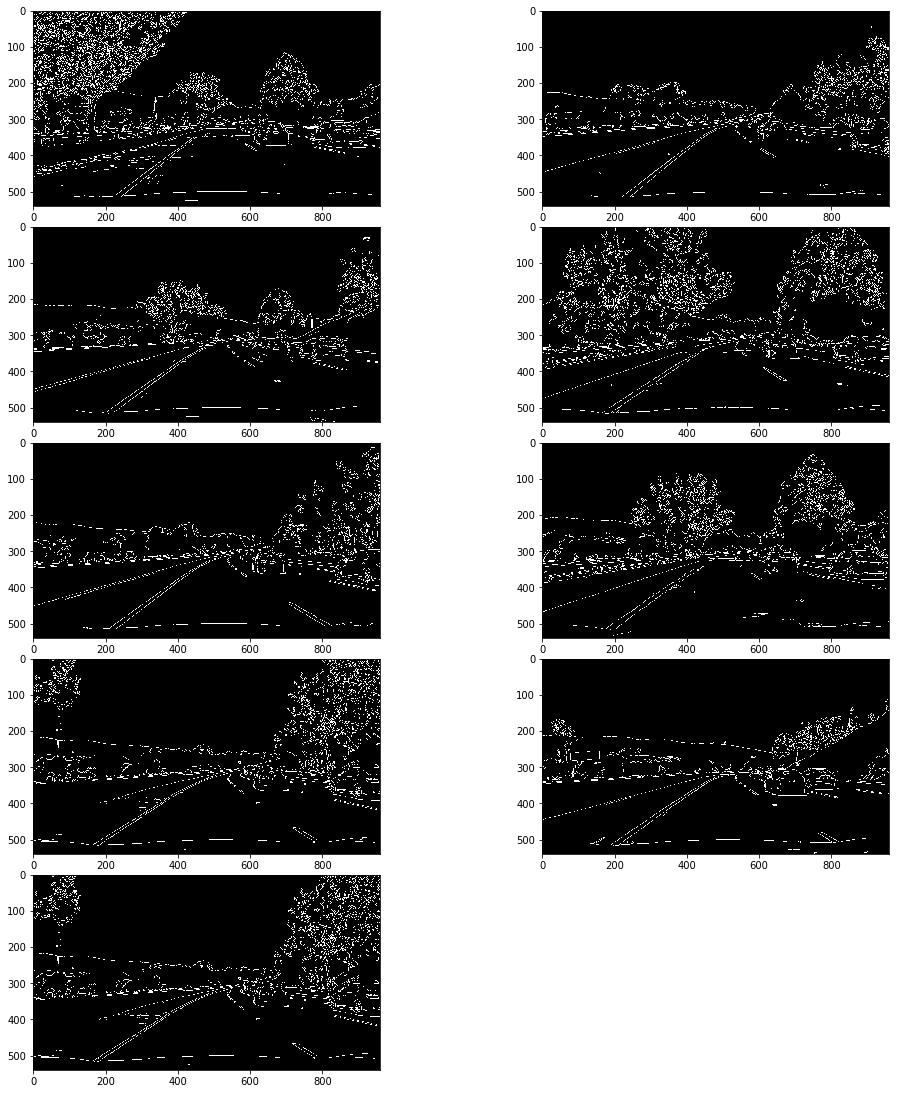

In [7]:
def canny(img, low_thresh, high_thresh):
    "Applies the Canny transform."
    return cv2.Canny(img, low_thresh, high_thresh)

blur_gray = [cv2.GaussianBlur(image, (5, 5), 0) for image in images_gray]
images_canny = [canny(image, 50, 150) for image in blur_gray]


display_images(images_canny, figsize = (15, 15))

## 4. Edge filtering based on edge orientation

Despite the optimization of high and low thresholds many noisy edges are still present in the figures. These edges cannot be filtered out through a proper choice of thresholds alone. We try to filter out the remaining noisy edges by exploting specific knowledge about lane lines. 

Typical lane lines have an angle with respect to the y-axis in the interval [15$^{\circ}$:165$^{\circ}$]. Any line which doesn't fall in this range is most likely a noisy edge. Based on this oberservation we developed an algorithm to filter out edges with an unusal low (or high) angle with respect to the y-axis.  

First the image is divided in a grid of quadratical subimages with a size of 20x20 pixels. Next the Hough transform is applied to each subimage in order to find all lines. The angle of each line with respect to the y-axis and its magnitude is computed afterwards. If the angle is not in the interval [15$^{\circ}$:165$^{\circ}$] the line is assigned to class 'no lane marking' otherwise to class 'lane marking'. Finally the sum of magnituds of all lines in class 'no lane marking' are compared to the sum of magnituds of all lines in class 'lane marking'. If the sum of class 'no lane marking' is larger than the one of class 'lane marking' the subimage is zeroed assuming that no lane line marking is contained in it. Otherwise the subimage is kept as is.

In [8]:
def subimage(image, size):
    """Return list of all sub-images. Each sub-image is represented by a tuple (sx1, sx2, sy1, sy2) such that
    image[sx1:sx2, sy1:sy2] gives the slice of the sub-image.
    
    Args:
    image -- image to be devided
    size  -- size of sub-image (sizexsize pixels). Size has to be a factor of xdim and ydim of image."""
    xdim, ydim = image.shape
    assert (xdim%size==0) and (ydim%size==0)
    nrow = ydim // size
    ncol = xdim // size
    return [(size*x, size*(x+1), size*y, size*(y+1))  for x in range(ncol) for y in range(nrow)]

def hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    """Return an array of lines found by the Hough transform [[x1, y1, x2, y2], ...].
    
    Args:
    image        -- binary image (e.g. output of the Canny function of opencv)
    rho          -- distance resolution in pixels 
    theta        -- angle resolution in radians
    threshold    -- threshold + 1 is the minimum number of votes a line needs to be returned
    min_line_len -- minimum length of line to be returned
    max_line_gap -- maximum distance of two line segments to be considered as a single line
    """
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
def draw_lines(image, lines, color=[255, 0, 0], thickness=1):
    """Return image with lines drawn on image.
    
    Args:
    image     -- original image
    lines     -- array of lines [[x1, y1, x2, y2], ...] (e.g. output of cv2.HoughLinesP)
    color     -- color of line (default: red)
    thickness -- thickness of line (default: 1)
    """
    # create color binary image
    imgl = np.zeros_like(image, dtype=np.uint8)
    if len(image.shape)==2:
        imgl = np.dstack((imgl, imgl, imgl))   
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(imgl, (x1, y1), (x2, y2), color, thickness) 
    return imgl

First we have to look for good values for the Hough transform. Again these parameters are found empirically. The Hough transformation hough_transform(rho, theta, threshold, min_line_len, max_line_gap) takes six parameters

* image: binary image (e.g. output of the Canny function of opencv)
* rho: distance resolution in pixels 
* theta: angle resolution in radiands
* threshold: threshold + 1 is the minimum number of votes a line needs to be returned
* min_line_len: minimum length of a line needed to be returned
* max_line_gap: maximum distance of two line segments to be considered as a single line

Again one needs to find a compromise between filtering out noisy lines and not filtering out real lines. A Hough transformation with parameters rho=1, theta=np.pi/180, threshold=10, min_line_len=5, max_line_gap=5 turned out to be good choice.

In [9]:
img = images_canny[0][310:320, 10:20]

lines = hough_lines(img, rho=1, theta=np.pi/180, threshold=6, min_line_len=5, max_line_gap=5)
img2 = draw_lines(img, lines, color=[255, 0, 0], thickness=1)

display_images([img, img2], figsize = (15, 7))

TypeError: 'NoneType' object is not iterable

The next chunk of code implements the filtering algorithm based on edge orientation.

In [10]:
def angle(v1, v2):
    "Return angle between vectors v1 and v2 in degrees."
    return np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))*180/np.pi

def sum_max_magn(v1, v2):
    "Return sum of vectors v1 and v2 such that the magnitude of the result vector is maximized."
    a = v1 + v2
    b = v1 - v2
    return a if np.linalg.norm(a) >= np.linalg.norm(b) else b

def line_vectors(image, thrAngle, rho, theta, threshold, min_line_len, max_line_gap):
    """Return two vectors: One representing the sum of all lines with an angle in range [thrAngle:180-thrAngle] with 
    respect to the y-axis and a sencond one for all lines in range [0:thrAngle] || [thrAngle:180-thrAngle]. 
    
    Return None for nl and/or ll if no line in the expected angular range was found.
    
    Args:
    image        -- binary image (e.g. output of the Canny function of opencv)
    thrAngle     -- threshold angle (see return values)
    rho          -- distance resolution in pixels 
    theta        -- angle resolution in radians
    threshold    -- threshold + 1 is the minimum number of votes a line needs to be returned
    min_line_len -- minimum length of line to be returned
    max_line_gap -- maximum distance of two line segments to be considered as a single line    
    Return values:
    nl           -- sum of all lines with an angle in range [0:thrAngle] || [thrAngle:180-thrAngle]
    ll           -- sum of all lines with an angle in range [thrAngle:180-thrAngle]
    """
    assert image.shape != (0, 0)
    lines = hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap)  
    nl = np.array([0, 0])
    ll = np.array([0, 0])
    if lines is None: # hough returns None if no lines were found (i.e. don't change original figure)
        return None, None
    ex = np.array([0, 1])
    for line in lines:
        x1, y1, x2, y2 = line[0] 
        el = np.array([y1, x1]) - np.array([y2, x2]) # numpy and opencv interchange rows and columns
        if (angle(el, ex) <= thrAngle) or (angle(el, ex) >= 180-thrAngle):
            nl = sum_max_magn(nl, el) 
        else:
            ll = sum_max_magn(ll, el) 
    if np.array_equal(nl, np.array([0, 0])):
        nl = None
    if np.array_equal(ll, np.array([0, 0])):
        ll = None    
    return nl, ll


def setup_grid(image, size, thrAngle, rho, theta, threshold, min_line_len, max_line_gap):
    """Return grid of sub-images with boolean value indicating if subimage contains potential lane line.

    Args:
    image        -- binary image (e.g. output of the Canny function of opencv)
    size         -- size of sub-images
    thrAngle     -- threshold angle (see return values)
    rho          -- distance resolution in pixels 
    theta        -- angle resolution in radians
    threshold    -- threshold + 1 is the minimum number of votes a line needs to be returned
    min_line_len -- minimum length of line to be returned
    max_line_gap -- maximum distance of two line segments to be considered as a single line    
    Return values:
    grid         -- Dictonary with keys indicating sub-image and boolean values indicating if sub-image contains lane line.
                    {(x1, x2, y1, y2) : True, (x1, x2, y1, y2): False, ...}
    """
    subs = subimage(image, size)
    grid = {}
    for sub in subs:
        x1, x2, y1, y2  = sub
        nl, ll = line_vectors(image[x1:x2, y1:y2], thrAngle, rho, theta, threshold, min_line_len, max_line_gap)
        if ll is None:
            grid[(x1, x2, y1, y2)] = False
        elif nl is None:
            grid[(x1, x2, y1, y2)] = True             
        elif np.linalg.norm(ll) >= np.linalg.norm(nl):
            grid[(x1, x2, y1, y2)] = True            
        elif np.linalg.norm(ll) < np.linalg.norm(nl):
            grid[(x1, x2, y1, y2)] = False 
    return grid    

def heatmap(image, grid):
    """Return image where sub-images with lane=True are highlighted in white (useful to visualize result of setup_grid)."""
    img = np.zeros_like(image)
    for coo, lane in grid.items():
        x1, x2, y1, y2 = coo
        if lane:
            img[x1:x2, y1:y2] = 255 
    return img

def filter_edge_orientation(image, grid):
    """Zeros all sub-images of image (as specified by grid) with lane=False
    
    Args:
    image        -- binary image (e.g. output of the Canny function of opencv)
    grid         -- output of setup_grid
    """
    for coo, lane in grid.items():
        x1, x2, y1, y2 = coo
        if not lane:
            image[x1:x2, y1:y2] = 0

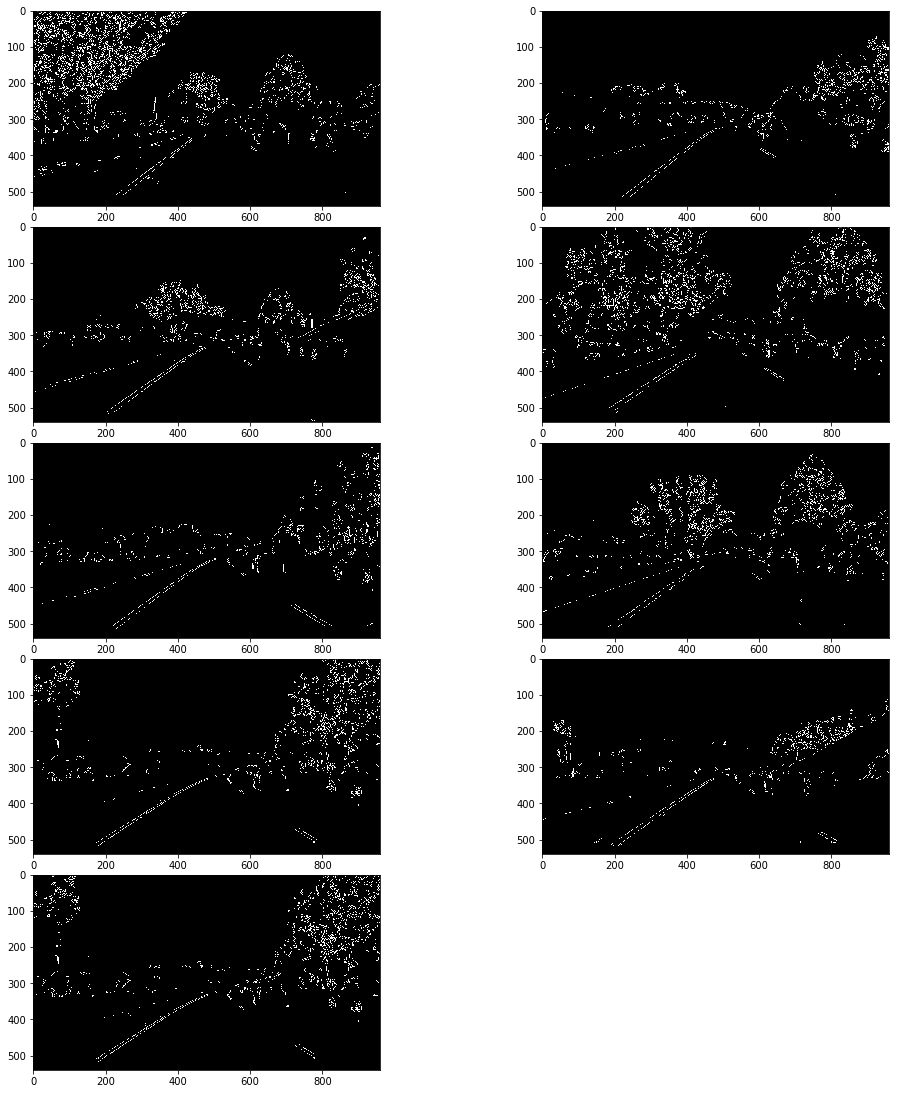

In [11]:
images_filter_eo = np.copy(images_canny)

grids = [setup_grid(image, size = 10, thrAngle = 15, rho = 1, theta = np.pi/180, threshold = 7, 
                    min_line_len = 5, max_line_gap = 5) 
        for image in images_canny]
[filter_edge_orientation(image, grid) for image, grid in zip(images_filter_eo, grids)] 
heatmaps = [heatmap(image, grid) for image, grid in zip(images_canny, grids)]

#display_images(heatmaps[0:4], figsize = (15, 3))
display_images(images_filter_eo, figsize = (15, 15))
#display_images(images_canny, figsize = (15, 15))

The filtering algorithm based on edge orientation works very well. A good portion of noisy edges has been filtered out. However, sometimes a sub-image is zeroed although it contained a piece of the actual lane line marking. In order to fix this issue we apply a mask which looks at the nei

In [12]:
def reconstruct_lane(grid, size):
    """Reconstruct grid: If neighbouring top left, top right or top sub-images contains line lane
    assume sub-image contains line lane as well."""
    agrid = grid.copy() # copy dict
    for coo, lane in grid.items():
        for neigh in neighbours(coo, size):
            if neigh in grid.keys() and grid[neigh]==True:
                agrid[coo] = True
    return agrid        
        
def neighbours(coo, size):
    "Return coordinates of the neighbouring sub-images on the top left, topright and top."
    x1, x2, y1, y2 = coo
    top = (x1 + size, x2 + size, y1, y2)
    topleft = (x1 + size, x2 + size, y1 - size, y2 - size)   
    topright = (x1 + size, x2 + size, y1 + size, y2 + size)
    return (topleft, top, topright)

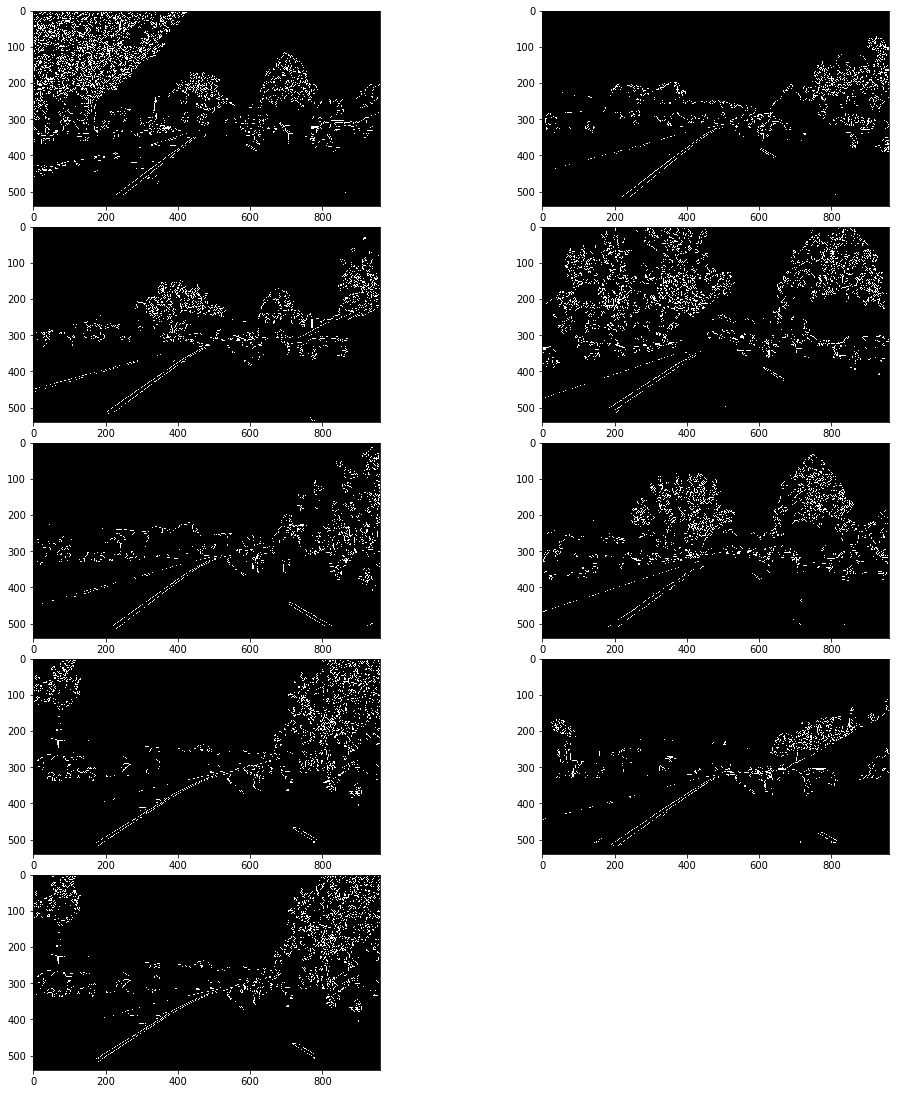

In [13]:
images_filter_eo = np.copy(images_canny)

grids = [reconstruct_lane(setup_grid(image, size = 10, thrAngle = 15, rho = 1, theta = np.pi/180, 
                                     threshold = 7, min_line_len = 5, max_line_gap = 5), size = 10) 
        for image in images_canny]
[filter_edge_orientation(image, grid) for image, grid in zip(images_filter_eo, grids)] 
heatmaps = [heatmap(image, grid) for image, grid in zip(images_canny, grids)]


#display_images(heatmaps[0:4], figsize = (15, 3))
display_images(images_filter_eo, figsize = (15, 15))
#display_images(images_canny[4:6], figsize = (15, 3))

On the expense of some additional noisy edges the lane lines have been reconstructed.

## 5. Edge filtering based on gradients

Although the previous algorithm filtered out many noisy edges there are still some present. We exploit two additional feature of lane line markings to distinguish them from noisy edges:
* lane line marking consists of two parallel lines (after application of the Cany edge detector)
* the direction of the gradient vector at the location of the lane lines falls in four ...

In [14]:
def phase(image):
    """Return angle of gradient vector at location of each pixel. Expects a gray-scale image.
    Angles are assigned to four quadrantes represented by integers between 1 and 4. 
    1: 270 <= angle <= 360
    2: 180 <= angle <  270
    3: 90  <= angle <  180
    4: 0   <= angle <   90
    """
    gradientX = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    gradientY = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
    angle = cv2.phase(gradientX, gradientY, angleInDegrees=True) 
    angle[(0 <= angle[:, :]) & (angle[:, :] < 90)]    = 4 
    angle[(90 <= angle[:, :]) & (angle[:, :] < 180)]  = 3
    angle[(180 <= angle[:, :]) & (angle[:, :] < 270)] = 2
    angle[(270 <= angle[:, :]) & (angle[:, :] <= 360)] = 1
    return angle    
    
def filter_pos_y(iq, fq, size, angle):
    """Check if pixel 'fq' is within 'size' pixels of pixel 'iq'. Otherwise zero pixel 'iq'.
    
    Search is done in increasing y-direction.    
    
    Args:
    iq -- quadrant of starting pixel
    fq -- quadrant we are looking for
    size -- size of windows in which we look for fq
    angle -- numpy array of angle values
    """
    _, ymax = angle.shape
    for pix in np.argwhere(angle == iq):
        flag = False
        for y in np.arange(pix[1], pix[1] + size, 1) :
            if y < ymax and angle[pix[0], y] == fq:
                flag = True
        if not flag:
            angle[pix[0], pix[1]] = 0

def filter_neg_y(iq, fq, size, angle):
    """Check if pixel 'fq' is within 'size' pixels of pixel 'iq'. Otherwise zero pixel 'iq'.
    
    Search is done in decreasing y-direction.
    
    Args:
    iq -- quadrant of starting pixel
    fq -- quadrant we are looking for
    size -- size of windows in which we look for fq
    angle -- numpy array of angle values
    """
    for pix in np.argwhere(angle == iq):
        flag = False
        for y in np.arange(pix[1], pix[1] - size, -1):
            if y >= 0 and angle[pix[0], y] == fq:
                flag = True
        if not flag:
            angle[pix[0], pix[1]] = 0
            
def filter_region(angle, left, right):
    """Divide image in two halves and filter out all pixel which are assigned to angular ranges 
    specified in 'right' but appear on the left of the figure (and viceversa).
    
    Args:
    angle  -- numpy array of angle values
    left   -- list of angular ranges expected to be in the left half of the figure 
    right  -- list of angular ranges expected to be in the right half of the figure 
    """
    xmax, ymax = angle.shape
    center = ymax//2
    for c in left:
        for pix in np.argwhere(angle == c):
            if pix[1] > center:
                angle[pix[0], pix[1]]=0
    for c in right:
        for pix in np.argwhere(angle == c):
            if pix[1] < center:
                angle[pix[0], pix[1]]=0         
    
    

def filter_gradient(imageg, image, width):
    """Filter out noisy edges of image based on assumptions of lane line markig width and direction of the gradient.
    
    Args:
    imageg       -- grayscale image
    image        -- binary image (e.g. output of the Canny function of opencv)
    width        -- maximum width of lane line         
    """
    angle = phase(imageg)
    mask = (image[:, :] == 255)
    angle[~mask] = 0
    filter_pos_y(1, 3, width, angle)  
    filter_pos_y(4, 2, width, angle)  
    filter_neg_y(3, 1, width, angle)  
    filter_neg_y(2, 4, width, angle) 
    #filter_region(angle, right = [1, 3], left = [2, 4])
    #angle[angle != 0] = 255
    return angle.astype('uint8')
    

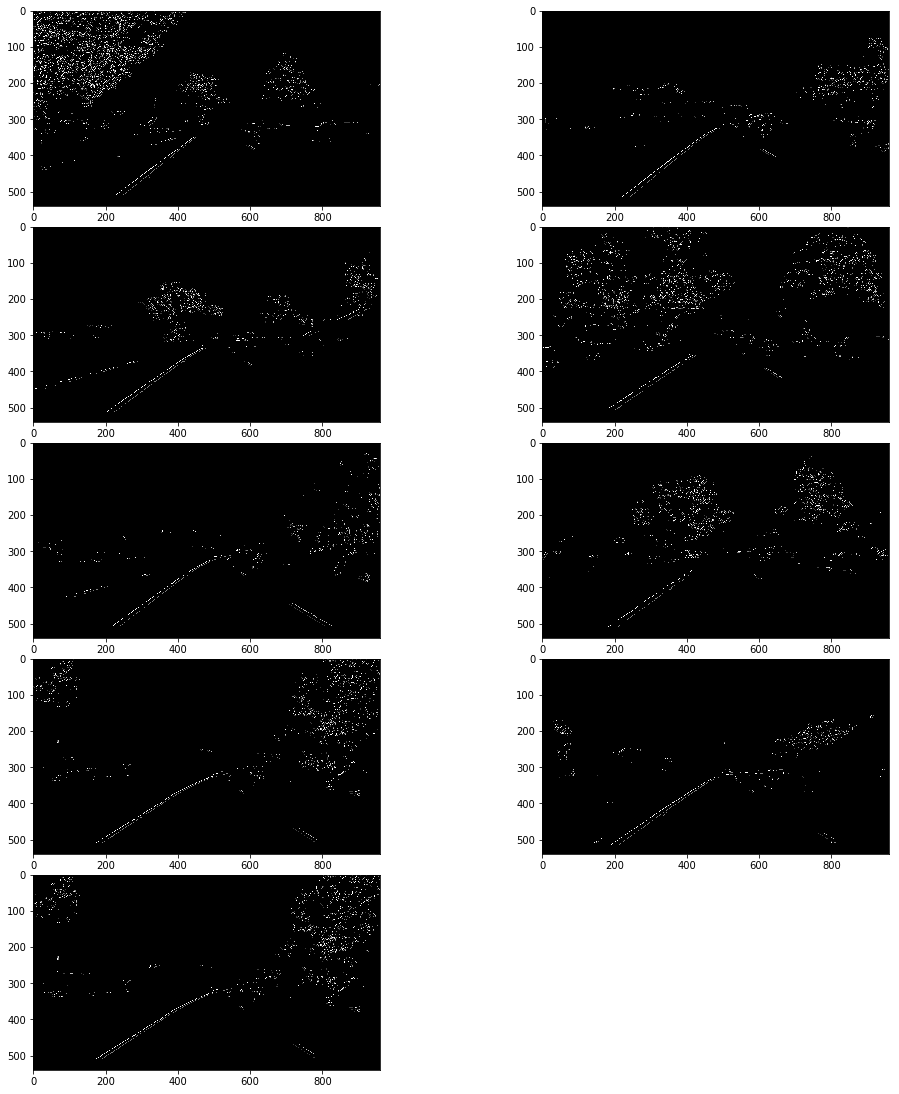

In [15]:
images_filter_g = [filter_gradient(p1, p2, 30)  for p1, p2 in zip(images_gray, images_filter_eo)]         
#images_filter_g = [filter_gradient(p1, p2, 30)  for p1, p2 in zip(images_gray, images_canny)]   
    
display_images(images_filter_g, figsize = (15, 15))

## 6. Regions selection

The region selection seems to be straight forward because all lane lines appear in the same general region of the pictures. The choice of the region has to take into account that a part of the car is visible at the bottom of some pictures. A polygon with four sides is a reasonable choice. It shouldn't be too restrictive. Objects which fall in this region but are not related to lane lines can still be suppressed through an appropriate filtering algorithms and a tuning of Cany and Hough algorithms.

Each original picture has a size of 540x960. I chose the region between 330 and 490 in x-direction and the full length in y-direction.

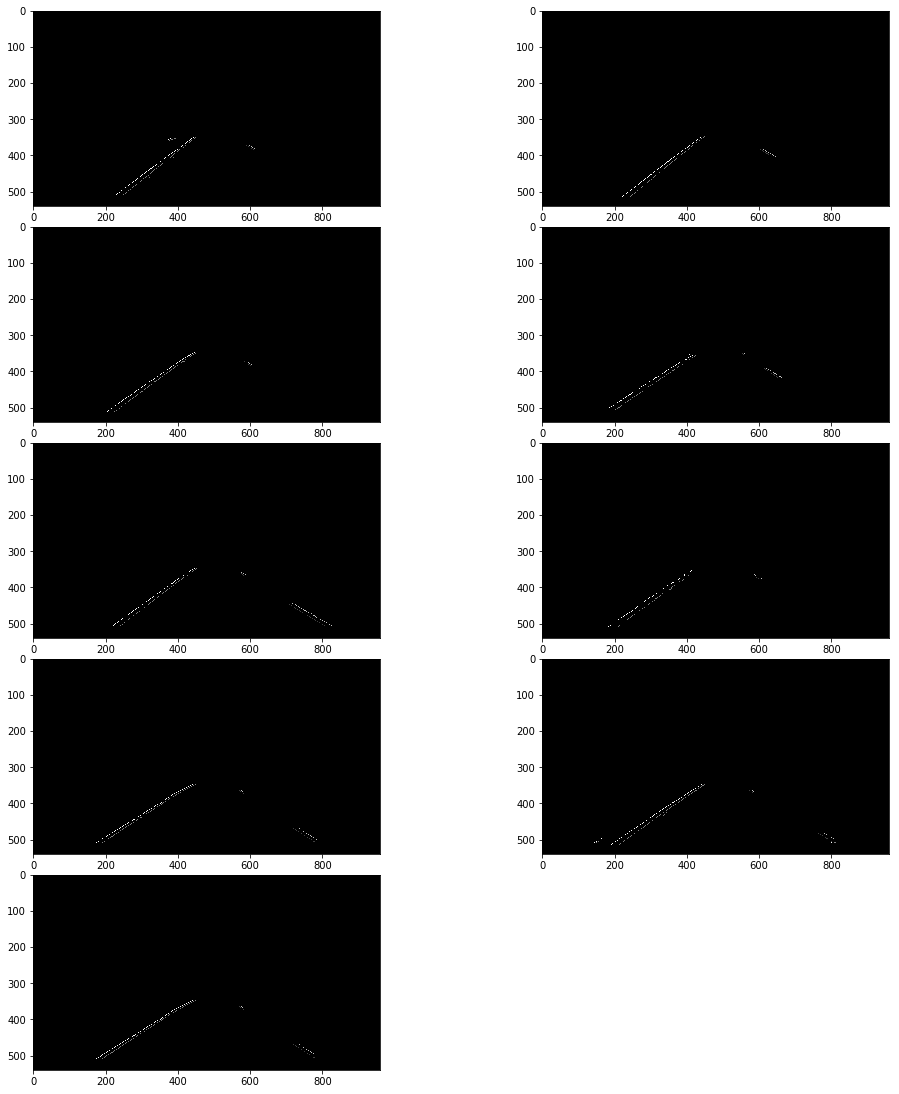

In [78]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    bottom_left = (0.10, 0.97)
    top_left = (0.41, 0.64)
    top_right = (0.59, 0.65)
    bottom_right = (0.96, 0.96)
    xdim, ydim  = img.shape
    bl_y, bl_x = bottom_left
    tl_y, tl_x = top_left
    tr_y, tr_x = top_right
    br_y, br_x = bottom_right
    v1 = int(bl_y*ydim), int(bl_x*xdim)
    v2 = int(tl_y*ydim), int(tl_x*xdim)
    v3 = int(tr_y*ydim), int(tr_x*xdim)
    v4 = int(br_y*ydim), int(br_x*xdim)
    vertices = np.array([[v1, v2, v3, v4]])   
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def region_of_interest2(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    v1 = (96, 523)
    v2 = (394, 349)  
    v3 = (566, 349) 
    v4 = (920, 523)
    vertices = np.array([[v1, v2, v3, v4]])   
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image




images_reg = [region_of_interest(image) for image in images_filter_g]

display_images(images_reg, figsize = (15, 15))


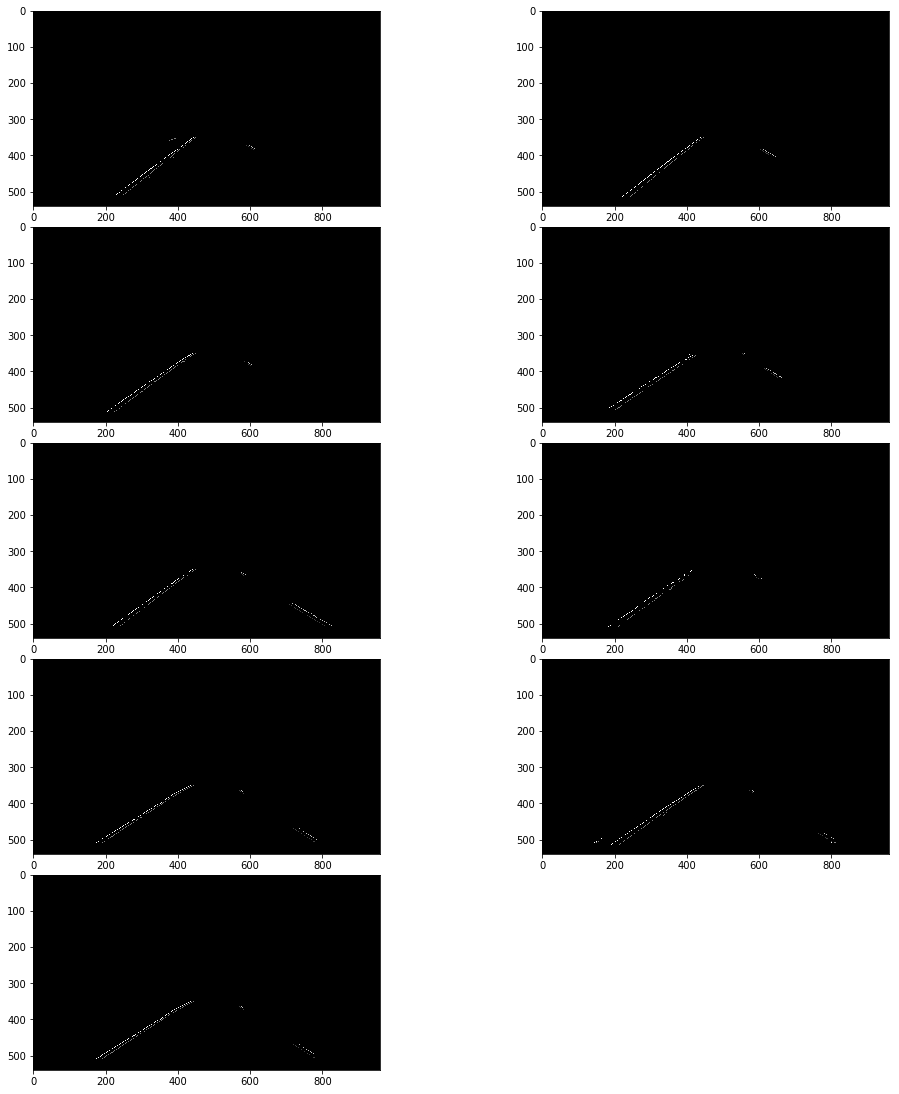

In [79]:
images_reg = [region_of_interest2(image) for image in images_filter_g]

display_images(images_reg, figsize = (15, 15))

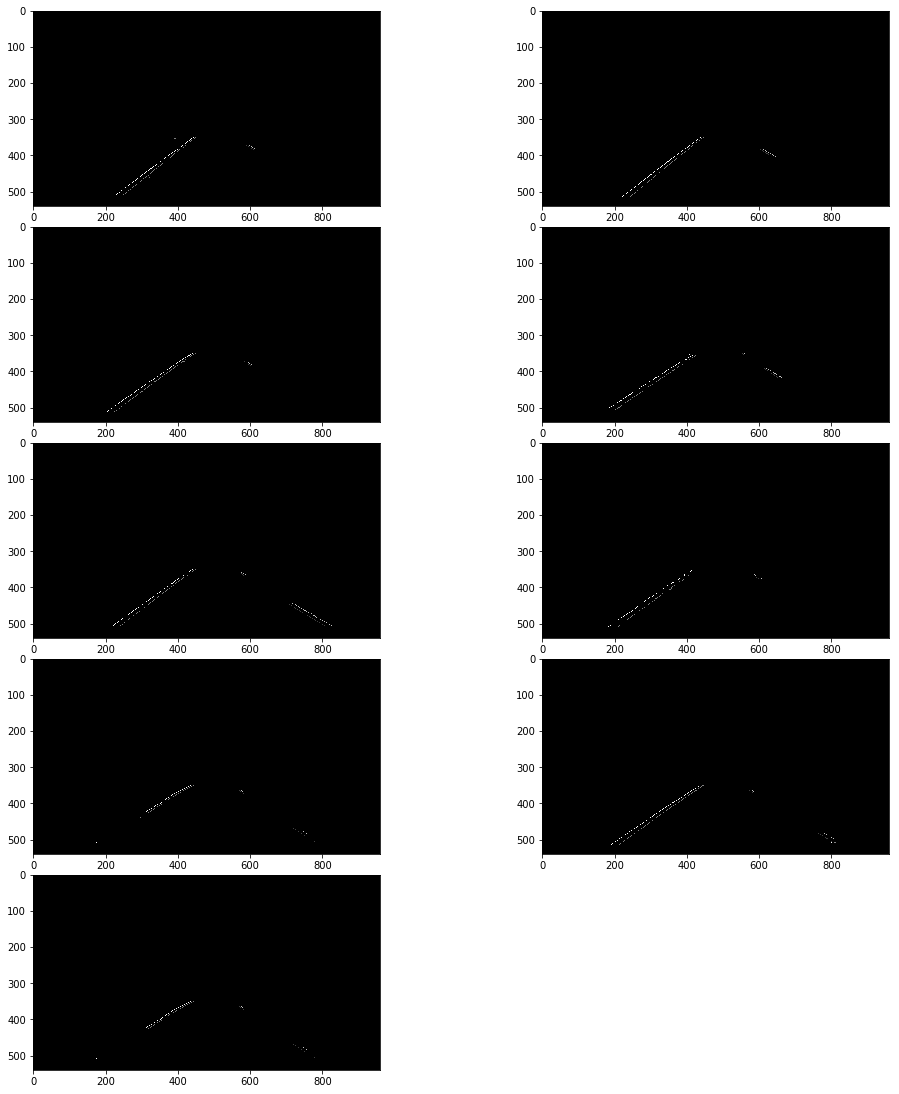

In [17]:
def otsu_filter(img, gimg):
    """Otsu
    """
    imgc = np.copy(img)
    blur = cv2.GaussianBlur(gimg, (5,5), 0)
    ret3, th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    mask = (th3 == 0)
    imgc[mask] = 0                          
    return imgc 

def otsu_filter2(img):
    """Otsu
    """
    blur = cv2.GaussianBlur(img, (5,5), 0)
    ret3, th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)                          
    return th3  
                              
images_otsu = [otsu_filter(p1, p2) for p1, p2 in zip(images_reg, images_gray)]
#images_otsu = [otsu_filter2(p1) for p1 in images_gray]


display_images(images_otsu, figsize = (15,15))
#display_images(images_filter_g[2:4], figsize = (15,15))

## 7. Finding lane lines

In [18]:
def average_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    avg = {}
    for classes in ((1, 3), (2, 4)):
        c1, c2 = classes
        img = np.copy(image) 
        mask = (img[:, :] == c1) | (img[:, :] == c2)
        img[~mask] = 0
        lines = hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap) 
        if lines is None:
            continue
        
        slope = []
        intercept = []
        length = []
        for line in lines:
            y1, x1, y2, x2 = line[0]  # interchanged x, y coordiantes
            if x1 == x2: continue
            slope.append((y1 - y2)/(x1 - x2))
            intercept.append(y1 - slope[-1]*x1 - slope[-1])
            length.append((x1-x2)**2 + (y1-y2)**2)
            
        # use length of lines as weights
        if slope and intercept and length:
            avgSlope = np.dot(slope, length) / sum(length)  
            avgIntercept = np.dot(intercept, length) / sum(length)      
            if classes == (1, 3):
                avg['right'] = (avgSlope, avgIntercept)
            else:
                avg['left'] = (avgSlope, avgIntercept)                
    return avg
    
def pixel_points(image, avg, upper=1):
    assert 0 < upper <= 1
    if len(image.shape)==2:
        xmax, ymax = image.shape
    else:
        xmax, ymax, _ = image.shape
    xmin = int(upper*xmax)
    points = {'left' : None, 'right' : None}
    for lane, line in avg.items():
        slope, intercept = line
        y1 = int(slope*xmax + intercept)
        y2 = int(slope*xmin + intercept)
        if lane == 'right':
            points['right'] = (y1, xmax, y2, xmin)
            #points['right'] = np.array([[[y1, xmax, y2, xmin]]])
        else:
            points['left'] = (y1, xmax, y2, xmin)
            #points['left'] = np.array([[[y1, xmax, y2, xmin]]])
    return points

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)
     
def draw_lines(image, lines, color=[255, 0, 0], thickness=1):
    """Return image with lines drawn on image.
    
    Args:
    image     -- original image
    lines     -- array of lines [[x1, y1, x2, y2], ...] (e.g. output of cv2.HoughLinesP)
    color     -- color of line (default: red)
    thickness -- thickness of line (default: 1)
    """
    # create color binary image
    imgl = np.zeros_like(image, dtype=np.uint8)
    if len(image.shape)==2:
        imgl = np.dstack((imgl, imgl, imgl))   
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(imgl, (x1, y1), (x2, y2), color, thickness) 
    return imgl    


def draw_lane_lines(image, line, color=[255, 0, 0], thickness=20):
    imgl = np.zeros_like(image)
    if line is not None:
        x1, y1, x2, y2 = line
        cv2.line(imgl, (x1, y1), (x2, y2),  color, thickness)
    return cv2.addWeighted(image, 1.0, imgl, 0.95, 0.0)
    
    

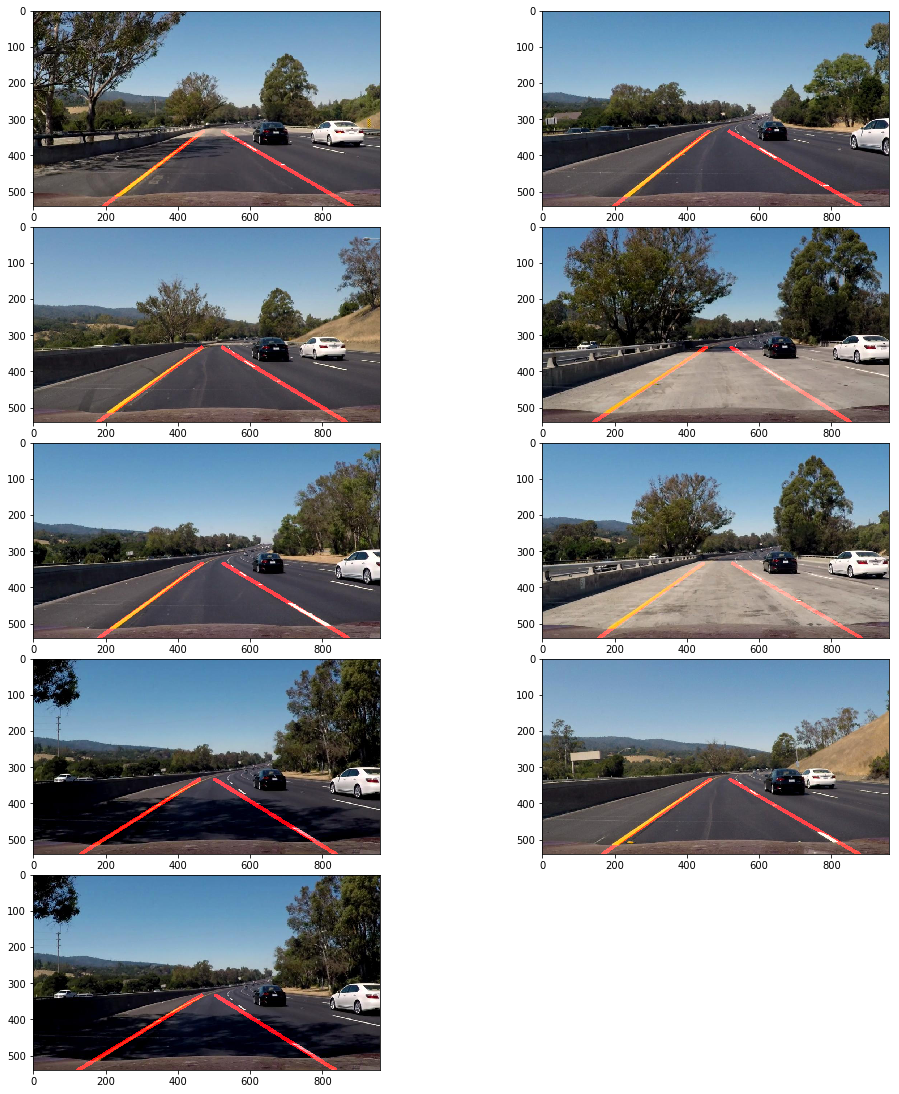

In [142]:
import collections

class FindLaneLines:
    def __init__(self):
        self.left = collections.deque(maxlen=10)
        self.right = collections.deque(maxlen=10)
        self.left_avg = (0, 0, 0, 0)
        self.right_avg = (0, 0, 0, 0)
        self.config = {
           # region
           'bottom_left' : (0.10, 0.97),
           'top_left' : (0.41, 0.64),     
           'top_right' : (0.59, 0.65),  
           'bottom_right' : (0.96, 0.96),
           # canny
           'low' : 50,
           'high' : 150,
           # filter noisy edges
           'size' : 10,
           'angle' : 15,
           'rho1' : 1,
           'theta1' : np.pi/180,
           'thresh1' : 7,
           'min_line_len1' : 5,
           'max_line_gap1' : 5,
           'width' : 30,
           # hough lines
           'rho2' : 1,
           'theta2' : np.pi/180,
           'thresh2' : 20,
           'min_line_len2' : 20,
           'max_line_gap2' : 300        
         }
                
        
    def process_image(self, image):
        # convert image to grayscale and search edges
        img_gray = grayscale2(image)
        #blur_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
        img_canny = canny(img_gray, self.config['low'], self.config['high'])
    
        # filter noisy edges
        grid = setup_grid(img_canny, 
                      size = self.config['size'], 
                      thrAngle = self.config['angle'], 
                      rho = self.config['rho1'], 
                      theta = self.config['theta1'], 
                      threshold = self.config['thresh1'], 
                      min_line_len = self.config['min_line_len1'], 
                      max_line_gap = self.config['max_line_gap1'])
        grid_re = reconstruct_lane(grid, self.config['size'])
        filter_edge_orientation(img_canny, grid_re)   
        images_filter_g = filter_gradient(img_gray, img_canny, self.config['width'])   
    
        # select region
        images_reg = region_of_interest(images_filter_g) 
    
        # apply otsu filter
        images_otsu = otsu_filter(images_reg, img_gray)
    
        # find lane lines
        avg = average_lines(images_otsu, 
                            rho = self.config['rho2'], 
                            theta = self.config['theta2'], 
                            threshold = self.config['thresh2'], 
                            min_line_len = self.config['min_line_len2'],
                            max_line_gap = self.config['max_line_gap2'])
        
        points =  pixel_points(image, avg, 0.62)  
        
            
        def aver_line(lines, line, avg, perc):
            if (line is not None):
                if (len(lines) < 10) or (outlier(avg, line, perc)):
                    lines.append(line) 
                
            if len(lines)>0:
                sumx1 = sumy1 = sumx2 = sumy2 = 0
                for line  in lines:
                    y1, x1, y2, x2 = line
                    sumy1 += y1
                    sumx1 += x1
                    sumy2 += y2
                    sumx2 += x2              
                line = (sumy1/len(lines), sumx1/len(lines), sumy2/len(lines), sumx2/len(lines))
                line = tuple(int(l) for l in line)
            return line
        
        def outlier(avg, line, perc):
            cond1 = line[0]*(1-perc) <= avg[0] <= line[0]*(1+perc) 
            cond2 = line[1]*(1-perc) <= avg[1] <= line[1]*(1+perc) 
            cond3 = line[2]*(1-perc) <= avg[2] <= line[2]*(1+perc) 
            cond4 = line[3]*(1-perc) <= avg[3] <= line[3]*(1+perc) 
            return cond1 and cond2 and cond3 and cond4
                    
        self.left_avg = aver_line(self.left, points['left'], self.left_avg, 0.25)
        self.right_avg = aver_line(self.right, points['right'], self.right_avg, 0.25)
            
        image = draw_lane_lines(image, self.left_avg, color=[255, 0, 0], thickness=10)
        image = draw_lane_lines(image, self.right_avg, color=[255, 0, 0], thickness=10)
        return image

    
    
pic = []
for img in images:
    detector = FindLaneLines()
    pic.append(detector.process_image(img))
    
display_images(pic, figsize = (15, 15))
        

## Test on Videos

In [141]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os


def process_video(video_input, video_output):
    detector = FindLaneLines()

    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process_image)
    processed.write_videofile(os.path.join('test_videos_output', video_output), audio=False)
    
  

In [140]:
%time process_video('solidWhiteRight.mp4', 'solidWhiteRight.mp4') 

%time process_video('solidYellowLeft.mp4', 'solidYellowLeft.mp4') 

%time process_video('challenge.mp4', 'challenge.mp4') 

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



 70%|██████▉   | 155/222 [01:19<00:35,  1.87it/s]


100%|█████████▉| 221/222 [01:52<00:00,  2.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2min 22s, sys: 446 ms, total: 2min 22s
Wall time: 1min 53s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 23%|██▎       | 155/682 [01:29<05:14,  1.68it/s]


 45%|████▌     | 309/682 [02:51<03:16,  1.89it/s]


 68%|██████▊   | 463/682 [04:10<01:58,  1.85it/s]


 90%|█████████ | 617/682 [05:40<00:34,  1.91it/s]


100%|█████████▉| 681/682 [06:13<00:00,  1.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7min 44s, sys: 1.42 s, total: 7min 45s
Wall time: 6min 15s
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



 62%|██████▏   | 155/251 [05:39<03:50,  2.40s/it]


100%|██████████| 251/251 [08:21<00:00,  1.62s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 9min 1s, sys: 2.39 s, total: 9min 4s
Wall time: 8min 24s
